# 3. Clasificación (LSTM)

**Alumnos**

- Aguilera Luzania José Luis
- Francisco Javier Castro Marquez

## Contenido
---

**Introducción**
- Clasificación de texto
- Objetivo de la libreta.

**Procesamiento de los datos**
- Librerías
- Cargar el *corpus*
- Datos necesarios: *Text* y *Category*
- Palabras vacías o *stopwords*
- Cargar el lematizador
- Procesamiento del texto
- Vectorización y características TFIDF
- Separación de los conjuntos de datos

**Métricas**
- Matriz de confusión

**Red LSTM (Long Short-Term Memory)**
- Introducción
- Datos
- Conjunto de entrenamiento y de pruebas
- Modelo
- Entrenamiento
- Resultados

## Introducción
---

#### Clasificación de texto

La clasificación de textos es la tarea de clasificar un documento en una categoría predefinida, es decir, si *d_j* es un documento del conjunto de documentos *D* y *{c_1, c_2, ..., c_n}* es el conjunto de categorías, entonces la clasificación de textos asigna una categoría *c_i* al documento *d_j*. El caso de la detección de noticias falsas se puede resolver como un problema de clasificación de textos, donde a cada noticia *n_i* del conjunto de noticias *N* le asignamos una categoría del conjunto *{true, fake}*.

El proceso de clasificación de textos se muestra en la siguiente figura:


<p align="center">
<img src="./Imagenes/proceso_clasificacion_textos.png" width="500">
</p>

#### Objetivo de la libreta

El objetivo de esta libreta es mostrar el procesamiento necesario del texto para después ser usado en un clasificador de texto y utilizar distintos métodos para clasificar el texto.

## MLflow Setup
---

In [1]:
import mlflow

# Traking ═══════════════════════════════════════════════════
track_uri = "http://localhost:5000"
mlflow.set_tracking_uri(track_uri)

# Generación del experimento ════════════════════════════════
experiment_name = "LSTM"
mlflow.set_experiment(experiment_name)

# Cargando la información ═══════════════════════════════════
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# Imprimir la información ═══════════════════════════════════
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 1.26.0
Tracking URI: http://localhost:5000
Nombre del experimento: LSTM
ID del experimento: 4


## Procesamiento de los datos
---

#### Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import spacy_spanish_lemmatizer
import pathlib
import pickle

from nltk.corpus import stopwords

from tqdm.notebook import tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dropout, Dense
from keras.layers import LSTM, Embedding, Bidirectional, TextVectorization
from keras import Sequential

from tensorflow.keras.utils import plot_model

seed = 43
np.random.seed(seed)

#### Datos adicionales para la librería `nltk`

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoseLuisAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseLuisAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Cargar el corpus

In [4]:
corpus = pd.read_csv('Datos/corpus_spanish_v3.csv', encoding='utf-8', index_col=0)
corpus.head()

,Category,Topic,Source,Headline,Text,Link
0,True,Science,El país,La NASA recupera el contacto con un satélite d...,La NASA recupera el contacto con un satélite d...,https://elpais.com/elpais/2018/02/01/ciencia/1...
1,True,Economy,El financiero,AMLO aceleraría el consumo y el crecimiento ec...,AMLO aceleraría el consumo y el crecimiento ec...,http://www.elfinanciero.com.mx/economia/amlo-a...
2,Fake,Sport,actualidadpanamericana.com,Compañero de James se ‘calvea’ y le juega pesa...,Al borde de un colapso nervioso quedó el hábil...,http://www.actualidadpanamericana.com/companer...
3,Fake,Politics,actualidadpanamericana.com,Dian gravará este año a los niños que recojan ...,"Mediante pupitrazo de último minuto anoche, el...",http://www.actualidadpanamericana.com/dian-gra...
4,Fake,Politics,actualidadpanamericana.com,Uribe asegura que insultó 358 guerrilleros,Muy temprano esta mañana el expresidente y aho...,http://www.actualidadpanamericana.com/uribe-as...


#### Palabras vacías o *stopwords*

Las *stopwords* o palabras vacías son aquellas que carecen de sentido de manera individual o sin una palabra clave o *keyword*. Se utilizan las *stopwords* proporcionadas por la librería `nltk` en conjunto con las obtenidas del repositorio "stopwords-es" del usuario [genediazjr](https://github.com/stopwords-iso/stopwords-es).

*Nota: Algunos documentos utilizan palabras o referencias en inglés, por lo que se anexarán las stopwords en inglés de la librería `nltk`*.

In [5]:
stopwords_spanish_nltk = stopwords.words('spanish')
stopwords_english_nltk = stopwords.words('english')
stopwords_spanish_json = list(pd.read_json('Datos/stopwords-es.json')[0])

stopwords_spanish = list(set(stopwords_spanish_nltk +
                             stopwords_english_nltk +
                             stopwords_spanish_json))

print(f'Stopwords count: {len(stopwords_spanish)}')

Stopwords count: 906


#### Cargar el lematizador

La lematización consisten en que dada una forma flexionada (plural, femenino, conjugada, etc.) se halla el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Por ejemplo: el lema de *"diré"*, *"dije"* y *"diríamos"* es *"decir"*. Utilizar los lemas permite conservar coherencia en el texto, mientras que se reduce su tamaño.

Para poder lematizar palabras en español se utiliza la librería `spacy` en conjunto con las reglas para lematización en español creadas por el usuario de github [pablodms](https://github.com/pablodms/spacy-spanish-lemmatizer).

Para poder utilizar el lematizador es necesario ejecutar los siguientes comandos en la consola o en una celda de jupyter.

```powershell
pip install -U pip setuptools wheel
python -m spacy download es_core_news_sm
python -m spacy download es_core_news_lg
python -m spacy_spanish_lemmatizer download wiki
```

In [6]:
spacy.require_gpu()
nlp = spacy.load('es_core_news_lg')
nlp.replace_pipe('lemmatizer', 'spanish_lemmatizer')

#### Procesamiento del texto

En el procesamiento requiere de dos funciones `process_text` y `get_processed_corpus`.

**Función: process_text**

Se encarga de procesar el texto realizando los siguientes pasos:
- Eliminar hipervínculos.
- Eliminar los saltos de línea.
- Cambiar las etiquetas de números, teléfonos, correos y urls por una en español.
- Eliminar todos los caracteres que no sean del español.
- Obtener los lemas de todas las palabras del texto.

**Función: get_processed_corpus**

Procesar las más de 3000 noticias que hay en el corpus no es una tarea que lleva su tiempo, para reducir el tiempo en el que se ejecuta la libreta y se realizan pruebas en los modelos se creo la función `get_processed_corpus` que procesar el corpus y guardarlo en un archivo para cargarlo después de modo que solo se procesa una vez y se puede utilizar cada vez que sea necesesario, en caso de querer procesarlo cada vez que se ejecute, solo es necesario eliminar el archivo `processed_corpus_spanish.csv`.

In [7]:
def process_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"http", "", text)
    text = re.sub("\n", " ", text)
    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    text = re.sub('[^ A-Za-z\dÁÉÍÓÚÑáéíóúñ/]+', ' ', text)
    text = [token.lemma_ for token in nlp(text)
            if token.is_alpha and
            not token.lemma_ in stopwords_spanish]
    text = ' '.join(text)

    return text


def get_processed_corpus():
    processed_corpus_file = pathlib.Path('Datos/processed_corpus_spanish.csv')
    if processed_corpus_file.is_file():
        df = pd.read_csv(processed_corpus_file, encoding='utf-8')
    else:
        # Procesar el texto.
        tqdm_notebook.pandas(desc="Procesando el texto")
        text_to_process = corpus['Text']
        text_to_process = text_to_process.progress_apply(process_text)

        # Procesar las etiquetas.
        text_labels = corpus['Category']
        text_labels = text_labels.astype('category').cat.codes

        # Guardar los datos procesados.
        df = pd.concat([text_to_process, text_labels], axis=1)
        df.columns = ['Text','Category']
        df.to_csv(processed_corpus_file, encoding='utf-8', index=False)

    return df['Text'], df['Category']

In [8]:
# Datos necesarios ══════════════════════════════════════════
X, y = get_processed_corpus()

# Numpy ═════════════════════════════════════════════════════
X = X.values
y = y.values

#### Separación de los conjuntos de datos

In [9]:
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=2021)

# Guardar el tamaño del conjunto de entrenamiento ═══════════
mlflow.log_param('test_size', str(test_size))

## Métricas
---

#### Matriz de confusión

Es una representación matricial de la predicción de los resultados, usualmente usada para describir el rendimiento de clasificación de un modelo en el conjunto de pruebas para los cuales el resultado es conocido.

- True Positives: Casos en los que predecimos SI y el valor real es SI.
- True Negatives: Casos en los que predecimos NO y el valor real es SI.
- False Positives: Casos en los que predecimos SI y el valor real es NO.
- False Negatives: Casos en los que predecimos NO y el valor real es SI.

In [10]:
def plot_confusion_matrix(y_test_values, y_predicted_values, method=''):
    cf_matrix = confusion_matrix(y_test_values, y_predicted_values)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fig, ax = plt.subplots(figsize = (7, 5.5))
    sns.heatmap(cf_matrix, annot = labels, ax = ax, fmt = '',cmap = 'Blues', annot_kws = {"size": 13})

    # Etiquetas, título y ticks
    label_font = {'size':'15'}
    ax.set_xlabel(' \nPredicción', fontdict = label_font)
    ax.set_ylabel('Valores reales\n', fontdict = label_font)

    title_font = {'size':'16'}
    cf_matrix_title = 'Matriz de confusión: ' + method + '\n'
    ax.set_title(cf_matrix_title, fontdict = title_font)

    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax.xaxis.set_ticklabels(['Fake', 'Real'])
    ax.yaxis.set_ticklabels(['Fake', 'Real'])

    # Guardar el archivo.
    plt.savefig(f'Plots/artifacts/matriz_confusion_{method}.png')
    mlflow.log_artifact(f'Plots/artifacts/matriz_confusion_{method}.png')

    plt.show()

## Red LSTM (Long Short-Term Memory)
---


#### Introducción

**RNN**

En las redes neuronales tradicionales las entradas y las salidas son independientes unas de otras, pero en caso en los que se requiera predecir la siguiente palabra de una sentencia, se requiere conocer la palabra anterior o varias palabras anteriores; el intentar predecir el final de una película será más o menos acertado dependiendo de la información previa.

Las RNN son redes con ciclos en ellas, permitiendo que la información persista. Las RNN no son muy diferentes a las redes tradicionales, se puede entender como múltiples copias de una red, cada una pasando un valor a la siguiente como se muestra en la imagen:

<br>
<p align="center">
<img src="./Imagenes/info/rnn.png" width="550">
</p>

Las RNN recuerdan información a través del tiempo. Es útil cuando se quiere predecir dada una secuencia de información, las redes que pueden recordar la información a largo plazo son llamadas LSTM (Long Short-Term Memory) o Memoria a Largo Plazo.

**Bi-LSTM**

Las redes bidireccionales son en realidad dos redes RNN LSTM juntas. Esta estructura permite obtener la información hacia adelante y hacia atrás. Utilizando redes bidireccionales la entrada se ejecuta en dos direcciones, una del pasado al futuro y otra del futuro al pasado preservando información de ambos puntos en el tiempo de la secuencia, pasado y futuro.

<br>
<p align="center">
<img src="./Imagenes/info/bi_lstm.png" width="550">
</p>

In [11]:
max_features = 5000
seq_length = 300
ngram_range = (1,1)

epochs = 10
batch_size = 128

# MLFlow Información ════════════════════════════════════════
mlflow.set_tag("version.mlflow", mlflow.__version__)
mlflow.set_tag("version.keras", keras.__version__)
mlflow.set_tag("version.tensorflow", tf.__version__)
mlflow.set_tag("seed", f"{seed}")

# MLFlow ════════════════════════════════════════════════════
mlflow.tensorflow.autolog()

# Capa de vectorización ═════════════════════════════════════
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=seq_length,
    ngrams=ngram_range
)

# Generación del vocabulario ════════════════════════════════
vectorize_layer.adapt(X)
vocab_size = len(vectorize_layer.get_vocabulary())

# Modelo ════════════════════════════════════════════════════
model_LSTM = Sequential([
    vectorize_layer,
    Embedding(vocab_size+1, seq_length),
    Dropout(0.5),
    Bidirectional(LSTM(16)),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar y entrenar el modelo ═════════════════════════════
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=128, validation_data=(X_test, y_test), verbose=1)

mlflow.log_params({
    'max_features': f'{max_features}',
    'vocab_size': f'{vocab_size}',
    'seq_length': f'{seq_length}',
    'ngram_range': f'{ngram_range}',
    'epochs': f'{epochs}',
    'batch_size': f'{batch_size}'
})

Epoch 1/10
19/19 [==============================] - 7s 163ms/step - loss: 0.6569 - accuracy: 0.6980 - val_loss: 0.5822 - val_accuracy: 0.7956
Epoch 2/10
19/19 [==============================] - 2s 102ms/step - loss: 0.5143 - accuracy: 0.7815 - val_loss: 0.4082 - val_accuracy: 0.7969
Epoch 3/10
19/19 [==============================] - 2s 99ms/step - loss: 0.3415 - accuracy: 0.8532 - val_loss: 0.2897 - val_accuracy: 0.9069
Epoch 4/10
19/19 [==============================] - 2s 102ms/step - loss: 0.2806 - accuracy: 0.9039 - val_loss: 0.3120 - val_accuracy: 0.8642
Epoch 5/10
19/19 [==============================] - 2s 105ms/step - loss: 0.2031 - accuracy: 0.9409 - val_loss: 0.2624 - val_accuracy: 0.8943
Epoch 6/10
19/19 [==============================] - 2s 116ms/step - loss: 0.1391 - accuracy: 0.9576 - val_loss: 0.2465 - val_accuracy: 0.9094
Epoch 7/10
19/19 [==============================] - 2s 105ms/step - loss: 0.0891 - accuracy: 0.9761 - val_loss: 0.2599 - val_accuracy: 0.9157
Epoch 8

INFO:tensorflow:Assets written to: C:\Users\JOSELU~1\AppData\Local\Temp\tmpmashrz44\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\JOSELU~1\AppData\Local\Temp\tmpmashrz44\model\data\model\assets
2022/05/18 04:06:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "D:\Github\Deteccion-de-Noticias-Falsas\Notebooks\virtualenv\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [12]:
model_plot_path = 'lstm_model.png'
plot_model(model_LSTM, to_file=model_plot_path)

mlflow.log_artifact(model_plot_path, 'lstm_model.png')

### Resultados

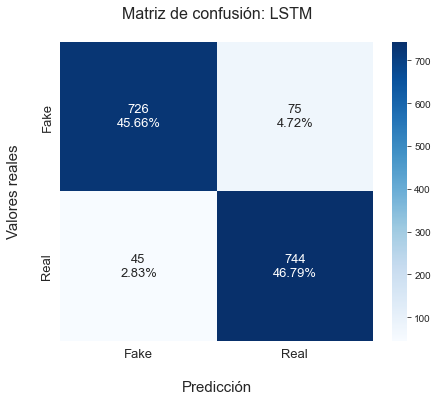

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       771
           1       0.94      0.91      0.93       819

    accuracy                           0.92      1590
   macro avg       0.92      0.93      0.92      1590
weighted avg       0.93      0.92      0.92      1590



In [13]:
# Predicción ════════════════════════════════════════════════
y_predicted_LSTM = (model_LSTM.predict(X_test) >= 0.5).astype(int)

# Resultados ════════════════════════════════════════════════
# Matriz de confusión
plot_confusion_matrix(y_predicted_LSTM, y_test, 'LSTM')

# Reporte de clasificación
print(classification_report(y_test, y_predicted_LSTM))

# Accuracy-score
accuracy_score_metric = accuracy_score(y_test, y_predicted_LSTM)

# Loss and Accuracy
f1_score_metric = f1_score(y_test, y_predicted_LSTM)

mlflow.log_metrics({
    'F1 Score': f1_score_metric,
    'Accuracy-Score': accuracy_score_metric
})

In [14]:
# Imprimiendo donde se encuentra la información
run_id = mlflow.last_active_run().info.run_id
print(f"Datos y modelo en la corrida: {run_id}")

# Terminar run.
mlflow.end_run()

Datos y modelo en la corrida: f6a5282ddf5a492eb21619eb0cbb7be2
